<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit8/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

**Answer2**:

A decision tree is a way of predicting data through simple binary decisions. For instance, when predicting with a continuous variable, the tree can essentially designate buckets the data falls into based on various thresholds (similar to knots in a bspline) and then assign some data to those buckets. For instance, that could be a mean of the data and therefore produce a horizontal line. We theoretically would probably also have it give a slope as well, but that would be more complex than we really need, as we can emulate it by making the depth go to infinity.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

**Answer3**:

The depth refers to how many layers there are at maximum. If it is balanced, this produces $2^{depth}$ leaf nodes (or buckets as I referred to them above). This will explicitly correlate to how closely it fits to the data, as if your depth produces a leaf for each data point, it will purely connect the dots. You can generally tell by looking at the graph of the model; if it is very jagged and taking into account every data point, it probably overfit. If it ignores a lot of datapoints (has too many in one bucket), it probably underfit.

**Task4:**

How are BART models similar and different from a decision tree?

**Answer4**:

'Similar' or 'different' are both somewhat misnomers for the relationship, given BARTs are composed of decision trees. It avoids the underfitting problem by having a number of shallower trees, with random roots to generate diversity. Thus, in order to improve the model, rather than improving the depth of one tree, we increase the breadth of the ensemble. This also helps avoid overfitting, as the trees are not all trying to fit the data in the same way.

**Task5**:

Why would we use a BART model instead of a decision tree?

**Answer5**:

Mostly talked about this above, but it significantly helps with overfitting. There's a lot of things it does on top of being an RF that I don't quite understand, but in general boost the diversity of the trees to capture more patterns in the data. Decision trees are relatively simple and can be very interpretable, but they are also very prone to overfitting. BARTs are more complex but still pretty interpretable along with being much more robust to overfitting and can capture more complex relationships in the data.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [2]:
import pandas as pd

#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [6]:
import pymc as pm
import pymc_bart as pmb
import numpy as np

predictors = penguins[['flipper_length', 'bill_depth', 'bill_length']]
predictand = penguins['body_mass']

with pm.Model() as BAAAAART:
    s = pm.HalfNormal('s',20) #random prior
    μ_ = pmb.BART("μ_", predictors, np.log(predictand), m=50) #log to make support R
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=predictand) #positive likelihood
    idata = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

Sampling: [y]


Output()

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


[Text(0.5, 1.0, 'Posterior Predictive'),
 Text(0.5, 0, 'flipper_length'),
 Text(0, 0.5, 'body_mass')]

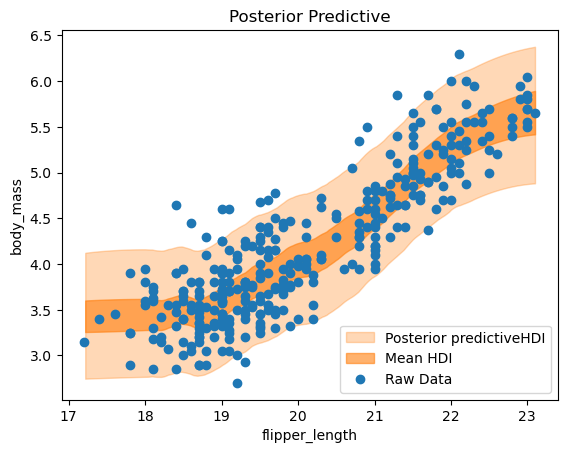

In [8]:
import arviz as az
import matplotlib.pyplot as plt

pm.sample_posterior_predictive(idata,BAAAAART, extend_inferencedata=True)

posterior_mean = idata.posterior["μ"]

μ_hdi = az.hdi(ary=idata, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata, group="posterior_predictive", var_names=["y"]
).T

idx = np.argsort(predictors.to_numpy()[:, 0]) #grab first row
fig, ax = plt.subplots()

az.plot_hdi(
    x=predictors.to_numpy()[:, 0],#grab first row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictiveHDI"},
)

az.plot_hdi(
    x=predictors.to_numpy()[:, 0],#grab first row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins['flipper_length'], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
)

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

**Answer8**:

Overall I think this does quite well. At the very low flipper lengths, there simply isn't much data, so it defaults to its flat trend. That likely isn't terribly accurate, but doesn't matter much. On the higher end it also goes back to horizontal, as BARTs are wont to do. However, it's hard to say whether that's purely BART being BART, or whether it truly does level off there. I wouldn't be surprised if at some point there is a natural limit t o the body mass, but I don't know enough about penguins to say for sure. Overall, it does a good job getting the relatively linear trend in the middle, and extrapolating where there are fewer data points, while ignoring some of the outliers towards the top.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

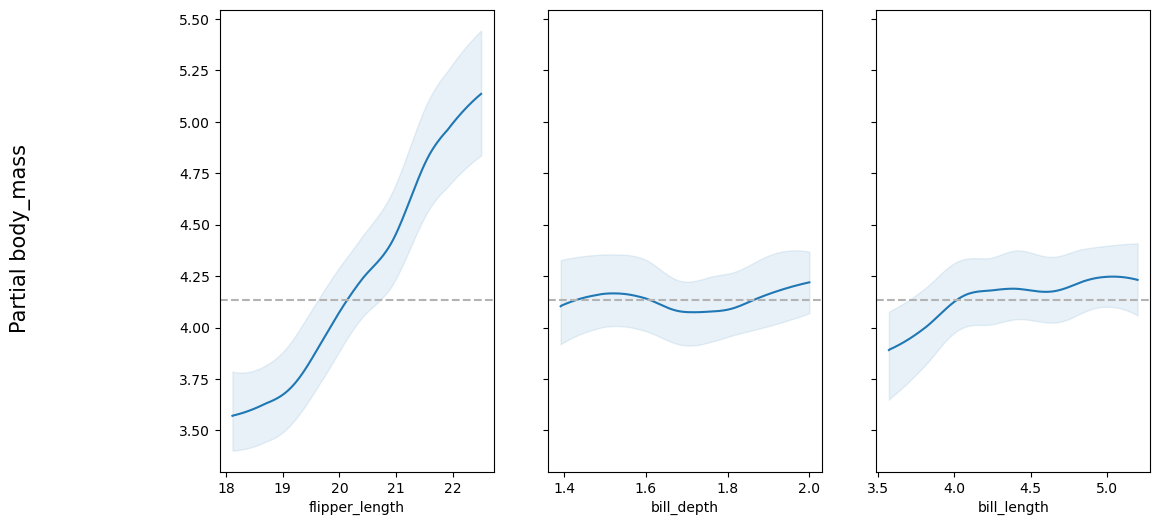

In [11]:
pmb.plot_pdp(μ_, predictors, predictand, grid=(1,3), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

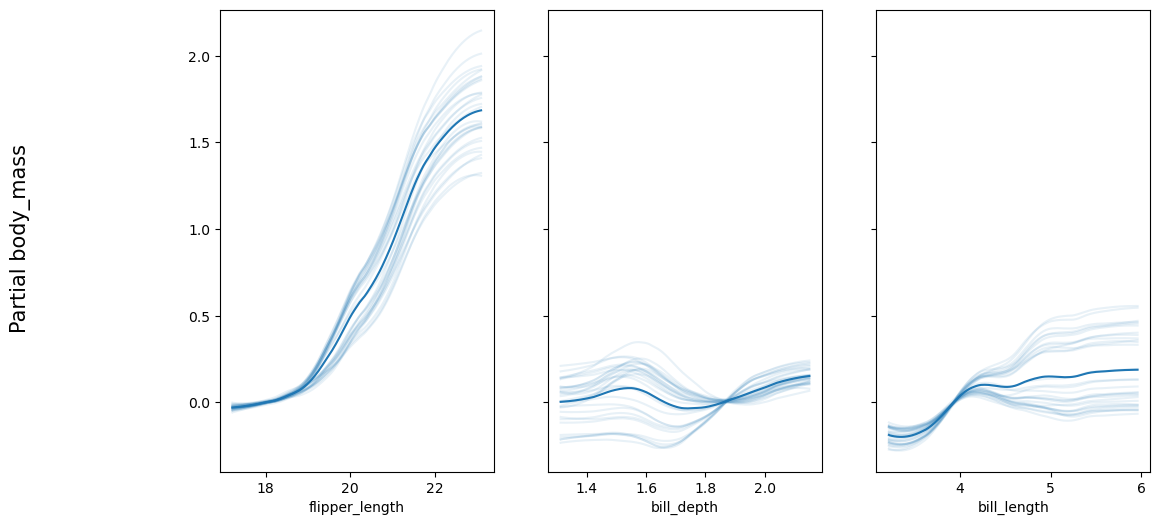

In [12]:
pmb.plot_ice( μ_, predictors, predictand, grid=(1, 3), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

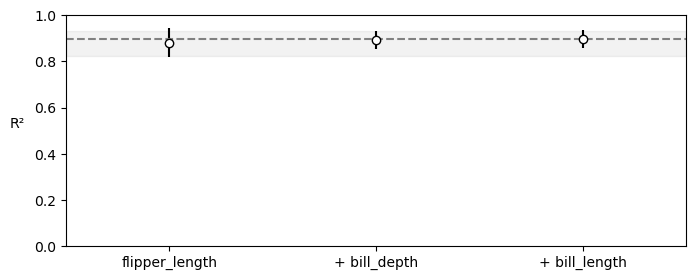

In [13]:
pmb.plot_variable_importance(pmb.compute_variable_importance(idata_counties, μ_, predictors))

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

**Answer10**:

The PDPs instantly show us quite a bit of info. For instance, flipper length has a pretty solid linear relationship with body weight at higher lengths (though notably not much impact at lower). However, bill depth and length have almost no correlation whatsoever. This is further noted by the ICE plots, which show relatively parallel lines for flipper length, simply deviating a little in severity at higher lengths. For bill depth in particular, they agree that it's relatively flat for higher depths, but are all over the place at lower ones. Inversely, bill_length agrees that there's a slight positive trend at first, but disagrees on how long that trend continues before flattening. They do all eventually flatten however, implying that there is a limited affect of bill length on body weight. Some even go back down at higher lengths, so there is likely another variable at play here. There is probably some limited interaction, particularly with the bill depth and length since they vary a significant amount, but not so much with flipper length which is generally consistent.

The VI tells us that flipper length is by far the most important variable, with bill depth and length being almost negligible. This is further supported by the PDPs, as flipper length has a clear linear relationship with body mass, while the other two are relatively flat. It also shows that purely flipper_length is actually quite a good predictor overall.